# SOGOS Overview for MLGeo 2022
**Southern Ocean Glider Observations of the Submesoscale**

In this notebook we attempt to [write motivation]

There are three main sections

Estimation of high-resolution pH by Random Forest

Notes 2022.12.02
- Check project_overview.md in ml-geo git folder for detailed variable notes
- Data comes from two gliders (sg660 and sg659), GO-SHIP cruise bottle sampling, and BGC-Argo
- gp_660, gp_659 --> *G*ridded-on-*P*ressure_#ID of glider

- Yeardays approximately 120-210 (May to August 2019)

## 0. Import Packages and Data

In [1]:
# Import packages 
import xarray as xr
import pandas as pd
import numpy as np
import gsw 
import matplotlib.pyplot as plt
from cmocean import cm as cmo
from datetime import datetime
import scipy
import glidertools as gt
import importlib
import seaborn as sns

import sogos_module as sg  # our custom module
# from sogos_module import lims, palettes

In [2]:
# Machine Learning/Statistics Packages
from scipy.stats import kde
from scipy.stats import iqr
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score


In [3]:
# Set up directories and import main dataframes
data_path = '../data/'
var_path = '../gridded-vars/'

# Import ship/float merged data to train the model 
total_DF = pd.read_csv(var_path + 'Merged_ShipFloat_DF_1202.csv', index_col=[0])

# Import glider data to run ML prediction on
df_659 = pd.read_csv(var_path + 'Glider659_DF_1202.csv', index_col=[0])  # flattened 2d array
df_660 = pd.read_csv(var_path + 'Glider660_DF_1202.csv', index_col=[0])

gp_659 = xr.open_dataset(data_path + 'gp_659_forMLGeo1026.nc') # pressure-gridded dataset
gp_660 = xr.open_dataset(data_path + 'gp_660_forMLGeo1026.nc')

# Original data files for ship and float before merging:
# float_directory = data_path + 'float/'
# ship_filepath =  data_path + 'bottle_data.csv'

# Optional import satellite data for plotting
# fsle = xr.open_dataset(file_path + 'fsle_backwards.nc')
# adt = xr.open_dataset(file_path + 'satellite_data.nc')

---
# Random Forest pH Prediction

**Steps for RF Model Training:**

1. Check feature correlations
2. Split data into training/test/validation
3. Train the model on ship and float data
4. Perform prediction
4. Compare model performance



## 1. Variable distributions and correlations

Text(0.5, 1.0, 'Correlation Heatmap')

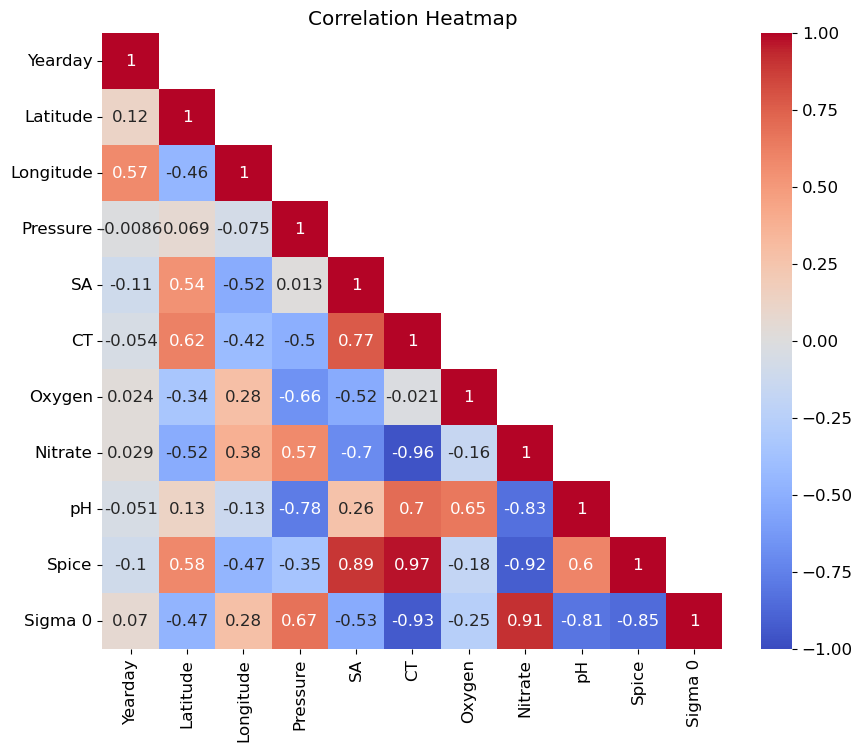

In [40]:
dfcorr = total_DF.drop({'Julian Day', 'Sigma 1', 'Sigma 2'},axis=1).corr()
# plot a heatmap with annotation

plt.figure(figsize=(10,8))
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(dfcorr, dtype=bool),k=1)
hm = sns.heatmap(dfcorr, mask=mask, annot=True, cmap='coolwarm', annot_kws={"size": 12}, center=0, vmin=-1, vmax=1)
plt.title('Correlation Heatmap')

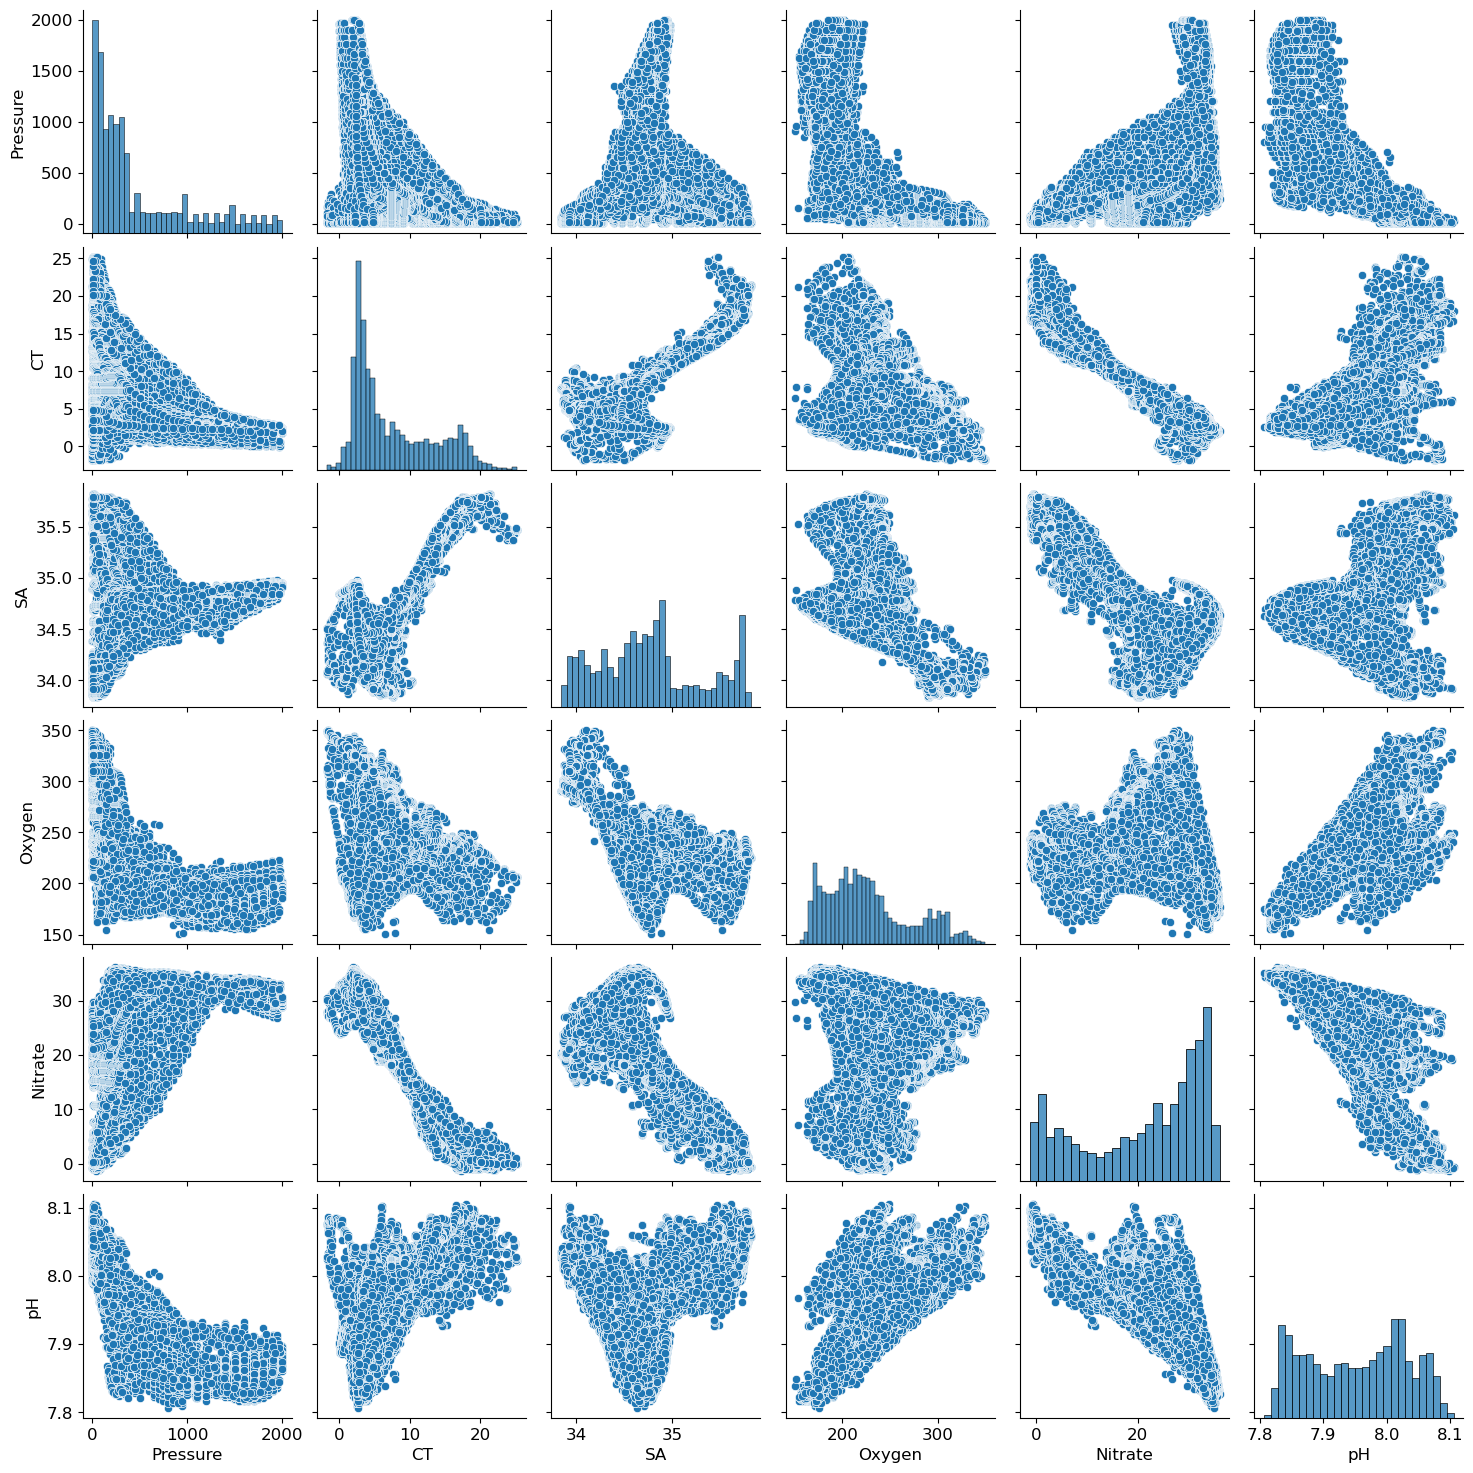

In [ ]:
# Pair Wise Plots
PWDF = total_DF[["Pressure", "CT", "SA", "Oxygen", "Nitrate", 'pH']]
sns.pairplot(PWDF)
# plt.savefig("PairPlot.png")
plt.show()

In [34]:
total_DF[total_DF.CT>5].describe()

,Yearday,Latitude,Longitude,Pressure,SA,CT,Oxygen,Nitrate,pH,Spice,Sigma 0,Sigma 1,Sigma 2
count,8071.000000,8071.000000,8071.000000,8071.000000,8071.000000,8071.000000,8071.000000,8071.000000,8071.000000,8071.000000,8071.000000,8071.000000,8071.000000
mean,541.808794,-40.328970,35.229211,232.466834,35.003578,11.972029,234.307942,12.012223,8.003707,1.627409,26.352694,30.775923,35.101440
std,290.596096,3.893278,15.680104,236.076375,0.601318,4.790530,33.701774,9.035950,0.054220,1.384028,0.576995,0.663777,0.751087
min,125.621470,-51.480000,18.050000,3.970000,33.839529,5.000390,150.700000,-1.320460,7.831326,-0.410631,23.505684,27.702678,31.808408
25%,259.240845,-44.538000,26.013000,63.789999,34.567746,7.648784,211.195305,3.427713,7.970257,0.340741,26.040576,30.373990,34.610242
50%,519.459699,-39.430000,30.001500,161.800003,35.076205,11.618510,225.581741,11.274165,8.012044,1.496131,26.503692,30.946975,35.290001
75%,802.084884,-37.508000,37.772000,312.000000,35.563116,16.162968,244.708557,20.249823,8.048375,2.887352,26.743227,31.257980,35.665691
max,1040.879826,-33.234300,90.376000,1249.580078,35.822362,25.206426,328.680267,32.506760,8.105666,5.201769,27.302312,31.876009,36.347692


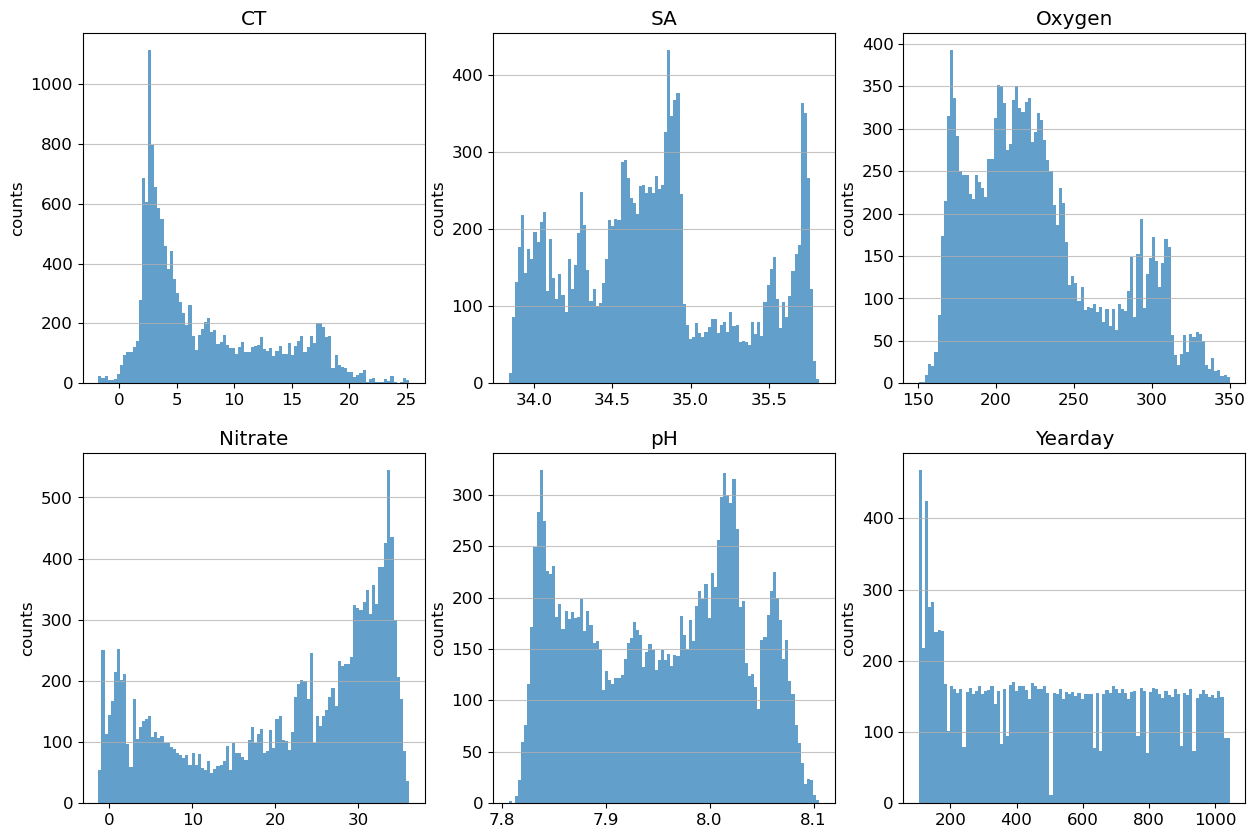

In [39]:
### Variable distributions from training ship/float data

nbins = 100
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
for i, var in enumerate(['CT', 'SA', 'Oxygen', 'Nitrate', 'pH', 'Yearday']):
    axs[i].hist(x=total_DF[var].values, bins=nbins, alpha=0.7)
    axs[i].grid(axis='y', alpha=0.75)
    axs[i].set_ylabel('counts')
    axs[i].set_title(var)



@JC: add interp?

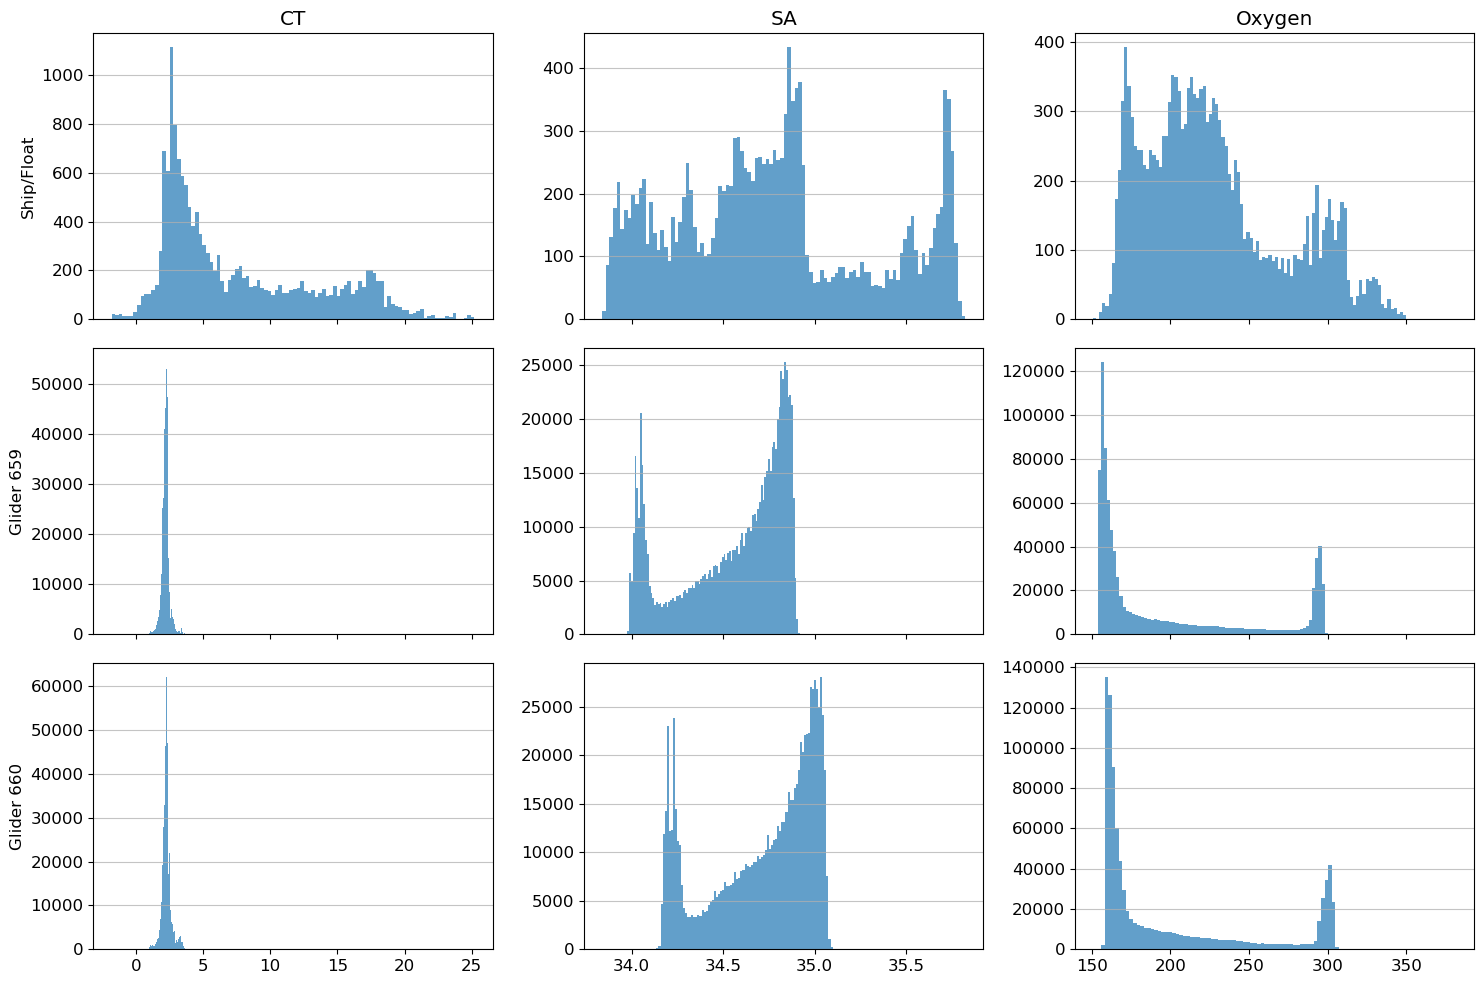

In [29]:
# Can compare with glider distributions

nbins = 100
fig, axs = plt.subplots(3, 3, figsize=(15, 10), tight_layout=True, sharex='col')
# axs = axs.flatten()
for c, var in enumerate(['CT', 'SA', 'Oxygen']):
    axs[0,c].hist(x=total_DF[var].values, bins=nbins, alpha=0.7)
    axs[1,c].hist(x=df_659[var].values, bins=nbins, alpha=0.7)
    axs[2,c].hist(x=df_660[var].values, bins=nbins, alpha=0.7)

    axs[0,c].set_title(var)

axs[0,0].set_ylabel('Ship/Float')
axs[1,0].set_ylabel('Glider 659')
axs[2,0].set_ylabel('Glider 660')

for ax in axs.flatten():
    ax.grid(axis='y', alpha=0.75)


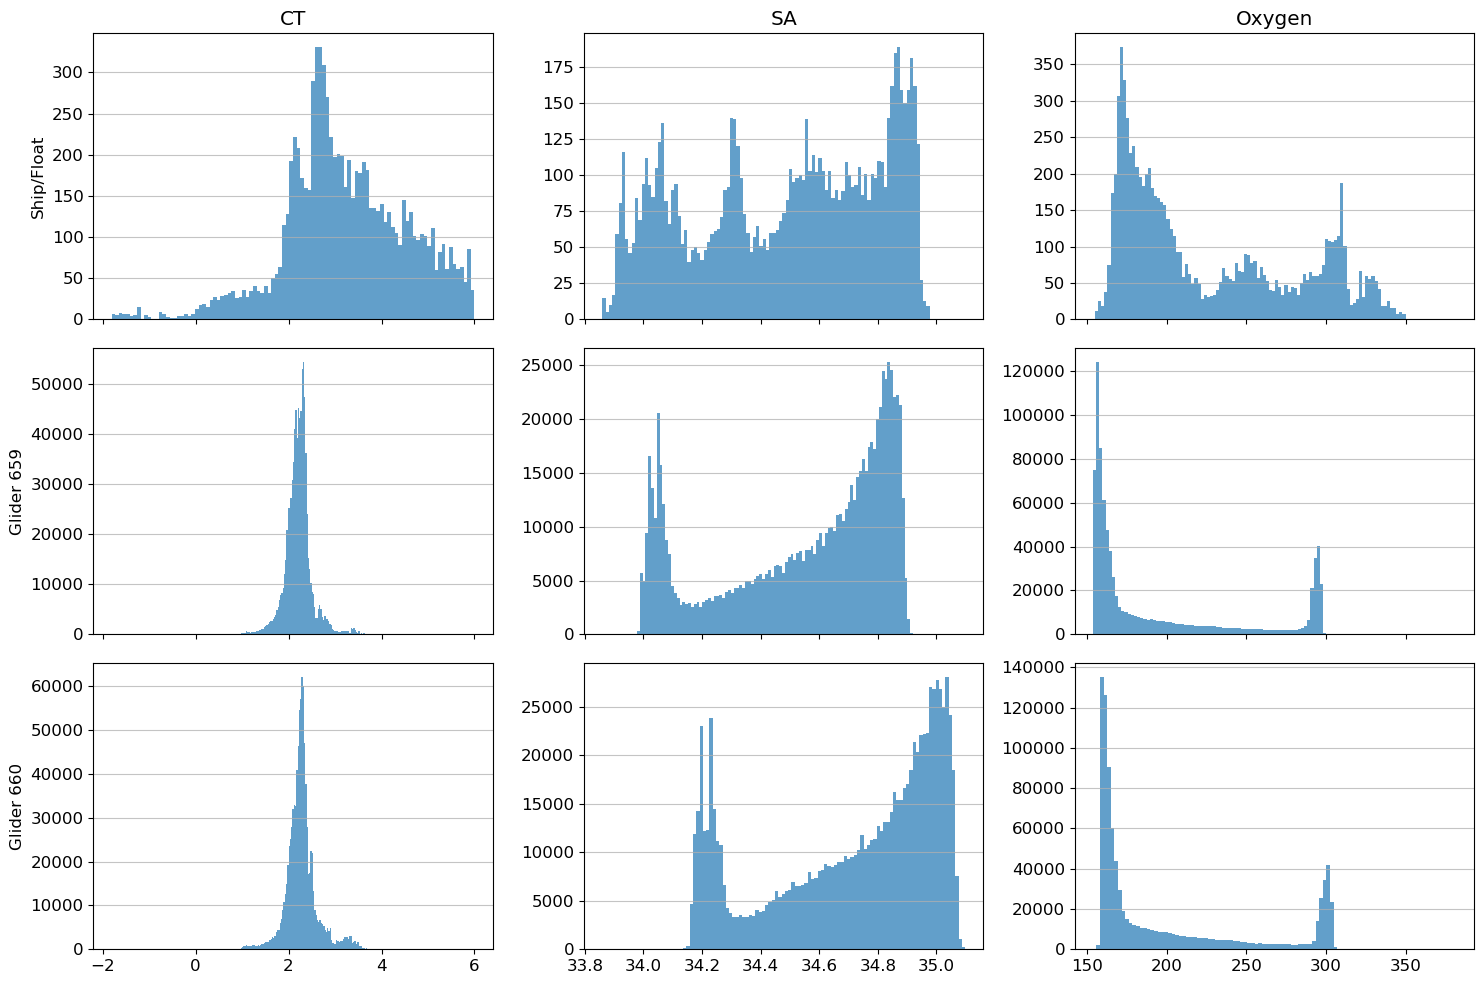

In [37]:
# quick check - does restricting CT range help distribution? 
dfs = total_DF[total_DF.CT<6]

nbins = 100
fig, axs = plt.subplots(3, 3, figsize=(15, 10), tight_layout=True, sharex='col')
# axs = axs.flatten()
for c, var in enumerate(['CT', 'SA', 'Oxygen']):
    axs[0,c].hist(x=dfs[var].values, bins=nbins, alpha=0.7)
    axs[1,c].hist(x=df_659[var].values, bins=nbins, alpha=0.7)
    axs[2,c].hist(x=df_660[var].values, bins=nbins, alpha=0.7)

    axs[0,c].set_title(var)

axs[0,0].set_ylabel('Ship/Float')
axs[1,0].set_ylabel('Glider 659')
axs[2,0].set_ylabel('Glider 660')

for ax in axs.flatten():
    ax.grid(axis='y', alpha=0.75)


## 2. Scale and split data

### 2.1 Feature Scaling

In [41]:
def scale_features(df):
    scaler = preprocessing.MinMaxScaler().fit(df.drop("Julian Day",axis=1))
    features = scaler.transform(df.drop("Julian Day",axis=1))
    feature_cols = df.drop("Julian Day",axis=1).columns
    return pd.DataFrame(features, columns=feature_cols)

In [42]:
scaled_DF = scale_features(total_DF)
scaled_DF.head()

,Yearday,Latitude,Longitude,Pressure,SA,CT,Oxygen,Nitrate,pH,Spice,Sigma 0,Sigma 1,Sigma 2
0,0.026586,0.949012,0.165058,0.001954,0.963034,0.853364,0.351513,0.019381,0.881308,0.848220,0.313164,0.290819,0.273184
1,0.026586,0.949012,0.165058,0.003958,0.963032,0.853335,0.351054,0.015298,0.878796,0.848185,0.313212,0.290864,0.273228
2,0.026586,0.949012,0.165058,0.005962,0.964039,0.853045,0.350520,0.015405,0.878563,0.848080,0.314053,0.291637,0.273947
3,0.026586,0.949012,0.165058,0.008968,0.968595,0.851657,0.348974,0.014863,0.872188,0.847513,0.317983,0.295251,0.277312
4,0.026586,0.949012,0.165058,0.010972,0.969102,0.850998,0.347439,0.014714,0.868493,0.846836,0.319283,0.296466,0.278460


### 2.2 Splitting Train/Test/Validation Data

In [ ]:
# archive: old import
# Use training_data.ipynb to create training datasets and save the training/test/validation datasets as .nc or .csv files
# Then, load the training data here

# file_path = "../data/"
# training = pd.read_csv(file_path + "SplitTraining_FloatShip_DF.csv")
# test = pd.read_csv(file_path + "SplitTest_FloatShip_DF.csv")
# validation = pd.read_csv(file_path + "SplitValidation_FloatShip_DF.csv")

In [43]:
# prepare the training dataset -- drop nitrate because the gliders do not have this variable
# therefore, we cannot use nitrate as a predictor for when we apply the model to glider tracks
features = scaled_DF.drop({'pH', 'Nitrate'},axis=1)
labels = scaled_DF[["pH"]]          # array of pH values to predict

- below looks great!

In [44]:
# Using Skicit-learn to split data into training and testing sets
# from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test_val, y_train, y_test_val = train_test_split(features, labels, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size = 0.5, random_state = 24)

# print(X_train.shape, X_test.shape, X_val.shape)
# print(y_train.shape, y_test.shape, y_val.shape)

print('From combined float and ship dataset, we have:')
print(str(X_train.shape[0]) + " training observations")
print(str(X_test.shape[0]) + " testing observations")
print(str(X_val.shape[0]) + " validation observations")

From combined float and ship dataset, we have:
12638 training observations
1580 testing observations
1580 validation observations


In [45]:
training = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
validation = pd.concat([X_val, y_val], axis=1)

In [ ]:
# Either implement or just comment n this in discussion:
# Bootstrapping to make multiple models by sampling differently --> would give a range of estimates at each point along the glider track
# Could average over all the results (flattened pH) to get a single estimate for each point along the glider track
# Could plot the mean, and also the std along the profile

In [10]:
# Save the three datasets
# os.mkdir('../gridded-vars/')
file_path = '../gridded-vars/'
training.to_csv(file_path + 'SplitTraining_DF_1202.csv') 
test.to_csv(file_path + 'SplitTest_DF_1202.csv')
validation.to_csv(file_path + 'SplitValidation_DF_1202.csv')

## 3. Train models on different feature sets

1. Minimal Model (Orthogonal axes)
2. Minimal + Spatial (Add geospatial dependence)
3. Minimal + Oxygen (Add biogeochemical data)
4. Measured Variables (Remove T-S reduction into spice, no density anomaly)

In [54]:
# Initialize variables to train the different models on 

var_list_1 = ["Spice", "Sigma 0"] 
var_list_2 = ["Spice", "Sigma 0", "Latitude", "Longitude"]
var_list_3 = ["Spice", "Sigma 0", "Oxygen"]
var_list_4 = ["SA", "CT", "Pressure", "Latitude", "Longitude", "Oxygen"]

ntrees = 1000
var_predict= 'pH'

In [47]:
# Create method to save error metrics for each version
def get_error_metrics(Y_pred_training, Y_training, Y_pred_test, Y_test, Y_pred_validation, Y_validation):
    AE_RF_training = Y_pred_training - Y_training
    IQR_RF_training = iqr(abs(AE_RF_training))

    AE_RF_test = Y_pred_test - Y_test
    IQR_RF_test = iqr(abs(AE_RF_test))

    AE_RF_validation = Y_pred_validation - Y_validation
    IQR_RF_validation = iqr(abs(AE_RF_validation))

    RF_dict = {}
    RF_dict["Model"] = ["Training", "Test", "Validation"]
    RF_dict["Median Absolute Error"] = [np.nanmedian(abs(AE_RF_training)), np.nanmedian(abs(AE_RF_test)), np.nanmedian(abs(AE_RF_validation))]
    RF_dict["IQR"] = [IQR_RF_training, IQR_RF_test, IQR_RF_validation]
    RF_DF = pd.DataFrame.from_dict(RF_dict)
    return RF_DF

In [48]:
def train_RF(var_list):
    Mdl = RandomForestRegressor(ntrees, max_features=1/3, oob_score = True, random_state = 0)

    # Create X Variables for each subset of data.
    X_training = training[var_list].to_numpy()
    X_validation = validation[var_list].to_numpy()
    X_test = test[var_list].to_numpy()

    Y_training = training[var_predict].to_numpy()
    Y_validation = validation[var_predict].to_numpy()
    Y_test = test[var_predict].to_numpy()
        
    # Train the model
    Mdl.fit(X_training, Y_training)

    # Estimate pH
    Y_pred_training = Mdl.predict(X_training)
    Y_pred_validation = Mdl.predict(X_validation)
    Y_pred_test = Mdl.predict(X_test)

    # Save error metrics
    Mdl_error = get_error_metrics(Y_pred_training, Y_training, Y_pred_test, Y_test, Y_pred_validation, Y_validation)

    return [Mdl, Mdl_error]

In [49]:
def plot_feat_importance(Mdl, var_list, save=False):
    Mdl.feature_importances_

    fig = plt.bar(var_list, Mdl.feature_importances_)
    plt.title("Random Forest Feature Importance")
    plt.xlabel("Feature")
    plt.ylabel("Out of Bag Feature Importance")
    plt.show()
    print('sum of feature importances: ' + str(sum(Mdl.feature_importances_)))
    
    if save:
        plt.savefig("RFFeatureImportancepH.png")
    return 

### 3.1 Minimal Model
- Add version with minimal parameters (just spice and potential density (these are orthogonal) to estimate pH)
- Use RF example from training_data.ipynb

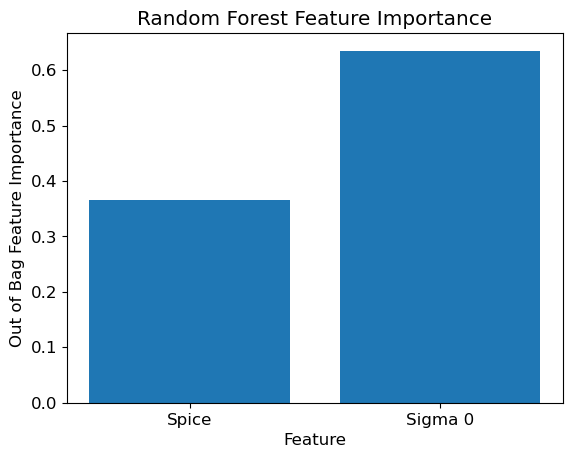

sum of feature importances: 1.0
Error Metrics for Model 1:
        Model  Median Absolute Error       IQR
0    Training               0.006211  0.010311
1        Test               0.016934  0.027704
2  Validation               0.016758  0.029637


In [52]:
[Mdl_1, err_1] = train_RF(var_list_1)
ax = plot_feat_importance(Mdl_1, var_list_1, save=False)
print('Error Metrics for Model 1:')
print(err_1)

### 3.2 Minimal + Spatial Model
- Add version with space information (spice, potdens + latitude/longitude to estimate pH)

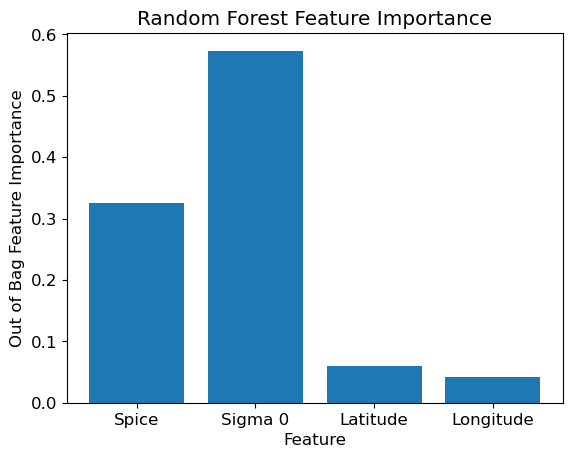

sum of feature importances: 1.0000000000000002
Error Metrics for Model 2:
        Model  Median Absolute Error       IQR
0    Training               0.006211  0.010311
1        Test               0.016934  0.027704
2  Validation               0.016758  0.029637


In [55]:
[Mdl_2, err_2] = train_RF(var_list_2)
ax = plot_feat_importance(Mdl_2, var_list_2, save=False)
print('Error Metrics for Model 2:')
print(err_1)

### 3.3: Minimal + BGC Model
- Add version including all data (CT, SA pressure, oxygen, lat, lon, buoyancy gradient(?) to estimate pH)
- May be overfitted because variables are so correlated to one another
- Perhaps should still not include time information (i.e. yearday or fake season component)?

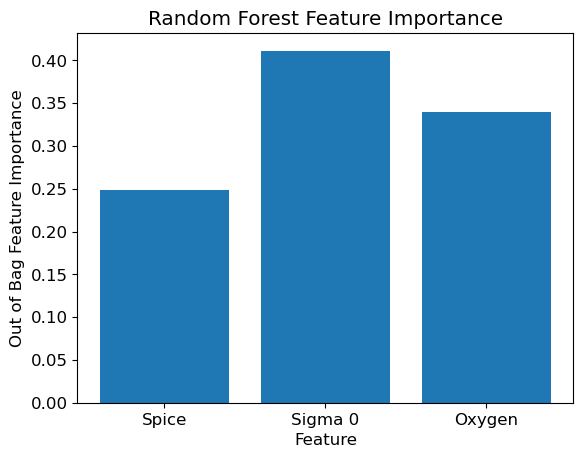

sum of feature importances: 1.0


In [57]:
[Mdl_3, err_3] = train_RF(var_list_3)
ax = plot_feat_importance(Mdl_3, var_list_3, save=False)

### 3.4 In-Situ Measured Feature Model

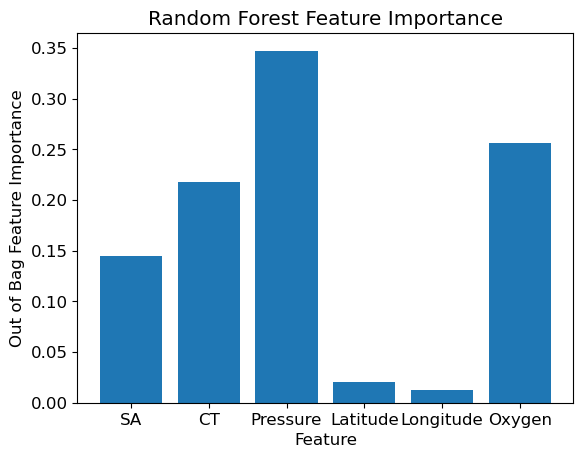

sum of feature importances: 1.0000000000000002


In [59]:

[Mdl_4, err_4] = train_RF(var_list_4) # runtime ~40 sec
plot_feat_importance(Mdl_4, var_list_4, save=False)

### 3.4b Include Yearday to above, show that it does not improve by much

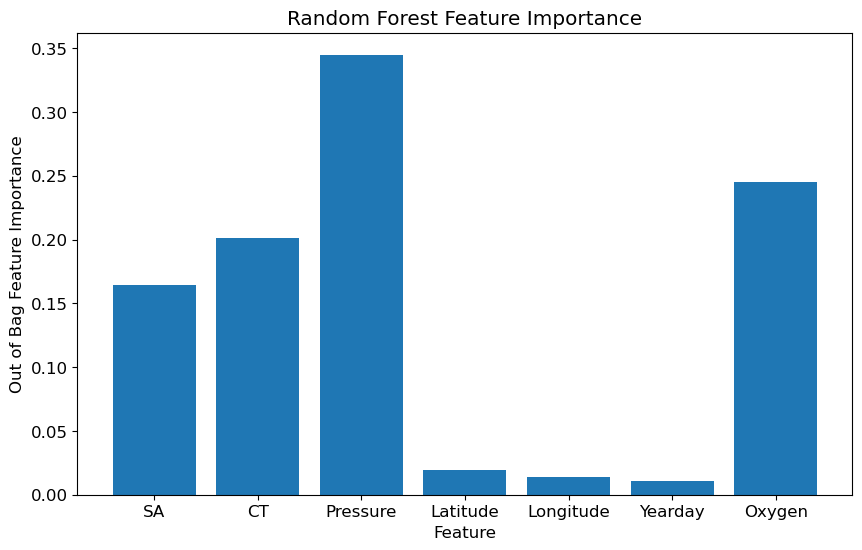

sum of feature importances: 1.0000000000000002


In [80]:
var_list_5 = ["SA", "CT", "Pressure", "Latitude", "Longitude", "Yearday", "Oxygen"]
[Mdl_5, err_5] = train_RF(var_list_5)
fig = plt.figure(figsize=(10,6))
plot_feat_importance(Mdl_5, var_list_5, save=False)

## **4. Glider pH Prediction**

Now run each model on the glider features using the same list of variables:

In [60]:
# Method to predict pH 
# Rescale pH values to original range after prediction

pHfactor = total_DF.pH.max() - total_DF.pH.min()
def rescale_pH(pH):
    return pH * pHfactor + total_DF.pH.min()
    
def predict_glider_pH(df_glider, var_list, Mdl):
    """Predicts pH glider data using the variables from var_list, from trained model
    Note this will return scaled pH values, so will need to be unscaled"""

    sdf_glider = scale_features(df_glider) 
    X_glider = sdf_glider[var_list].to_numpy()
    Y_pred_glider = Mdl.predict(X_glider)
    Y_pred_glider = rescale_pH(Y_pred_glider)

    return Y_pred_glider


In [61]:
# Original range of float and ship pH for comparison
total_DF.pH.describe()

count    15798.000000
mean         7.953029
std          0.078183
min          7.806794
25%          7.879045
50%          7.960109
75%          8.018906
max          8.105666
Name: pH, dtype: float64

In [62]:
# # Predict glider 659 pH, runtime over 3 models ~ 1m 40sec

df_659['pH_1'] = predict_glider_pH(df_659, var_list_1, Mdl_1)
df_659['pH_2'] = predict_glider_pH(df_659, var_list_2, Mdl_2)
df_659['pH_3'] = predict_glider_pH(df_659, var_list_3, Mdl_3)
df_659['pH_4'] = predict_glider_pH(df_659, var_list_4, Mdl_4)

In [67]:
pH_659 = df_659[['pH_1', 'pH_2', 'pH_3', 'pH_4']]
pH_659.rename(columns={'pH_1': 'minimal', 'pH_2': 'spatial', 'pH_3': 'oxygen', 'pH_4' : 'measured'})
pH_659.describe()

,pH_1,pH_2,pH_3,pH_4
count,862039.000000,862039.000000,862039.000000,862039.000000
mean,7.983750,7.978054,7.959479,7.949739
std,0.056493,0.042807,0.052535,0.036504
min,7.909490,7.900686,7.899040,7.881956
25%,7.921679,7.933745,7.905139,7.931574
50%,7.992397,7.990466,7.960155,7.939078
75%,8.036977,8.012102,8.016344,7.945720
max,8.081952,8.078757,8.067764,8.074678


In [68]:
# # Predict glider 660 pH, runtime over 3 models  ~ 1m 50sec

df_660['pH_1'] = predict_glider_pH(df_660, var_list_1, Mdl_1)
df_660['pH_2'] = predict_glider_pH(df_660, var_list_2, Mdl_2)
df_660['pH_3'] = predict_glider_pH(df_660, var_list_3, Mdl_3)
df_660['pH_4'] = predict_glider_pH(df_660, var_list_4, Mdl_4)

pH_660 = df_660[['pH_1', 'pH_2', 'pH_3']]
pH_660.rename(columns={'pH_1': 'minimal', 'pH_2': 'spatial', 'pH_3': 'oxygen', 'pH_4' : 'measured'})
pH_660.describe()

,pH_1,pH_2,pH_3
count,947968.000000,947968.000000,947968.000000
mean,7.986015,7.982972,7.965663
std,0.058519,0.047611,0.059609
min,7.909490,7.900890,7.899089
25%,7.921714,7.930900,7.905160
50%,7.995159,7.995394,7.963192
75%,8.044607,8.024113,8.028782
max,8.096140,8.077664,8.076970


In [141]:
gp_659['pH_1'] = sg.dfvar_to_darray(df_659, 'pH_1')
gp_659['pH_2'] = sg.dfvar_to_darray(df_659, 'pH_2')
gp_659['pH_3'] = sg.dfvar_to_darray(df_659, 'pH_3')
gp_659['pH_4'] = sg.dfvar_to_darray(df_659, 'pH_4')

In [142]:
gp_660['pH_1'] = sg.dfvar_to_darray(df_660, 'pH_1')
gp_660['pH_2'] = sg.dfvar_to_darray(df_660, 'pH_2')
gp_660['pH_3'] = sg.dfvar_to_darray(df_660, 'pH_3')
gp_660['pH_4'] = sg.dfvar_to_darray(df_660, 'pH_4')


### 5. Compare and assess models

In [72]:
print('Model 1: ' + str(var_list_1))
print(err_1); print('')

print('Model 2: ' + str(var_list_2))
print(err_2); print('')

print('Model 3: ' + str(var_list_3))
print(err_3); print('')

print('Model 4: ' + str(var_list_4))
print(err_4); print('')


Model 1: ['Spice', 'Sigma 0']
        Model  Median Absolute Error       IQR
0    Training               0.006211  0.010311
1        Test               0.016934  0.027704
2  Validation               0.016758  0.029637

Model 2: ['Spice', 'Sigma 0', 'Latitude', 'Longitude']
        Model  Median Absolute Error       IQR
0    Training               0.002910  0.004589
1        Test               0.007641  0.012124
2  Validation               0.007934  0.013150

Model 3: ['Spice', 'Sigma 0', 'Oxygen']
        Model  Median Absolute Error       IQR
0    Training               0.004011  0.006439
1        Test               0.010883  0.016839
2  Validation               0.010881  0.017388

Model 4: ['SA', 'CT', 'Pressure', 'Latitude', 'Longitude', 'Oxygen']
        Model  Median Absolute Error       IQR
0    Training               0.002291  0.003596
1        Test               0.006173  0.009721
2  Validation               0.006197  0.009333



- Notice the validation median absolute error goes down as you add more variables. However, Model 3 may be overfitted and may underperform with data from a slightly different spatial region
- For example, if you took a totally separate float from a different region in the Southern Ocean ACC (perhaps near Kerguelen), you might find that Model 1 actually does better than Model 3 because it is not as dependent on specific spatial information
- Another compromise could be to add Model 4, with Spice, Sigma 0, and Oxygen since these should be three separate axes

In [87]:
import seaborn as sns

In [181]:
pal = sns.color_palette('Set3', n_colors = 9)

dict = {'Spice' : pal[2],
        'Sigma 0' : pal[3],
        'Latitude' : pal[0],
        'Longitude' : pal[1],
        'Yearday' : pal[8],
        'Oxygen' : pal[5],
        'CT' : pal[6],
        'SA' : pal[7],
        'Pressure' : pal[4]}

pald = {'Mdl_1': [dict[v] for v in var_list_1],
        'Mdl_2': [dict[v] for v in var_list_2],
        'Mdl_3': [dict[v] for v in var_list_3],
        'Mdl_4': [dict[v] for v in var_list_4],
        'Mdl_5': [dict[v] for v in var_list_5]}

# pal[0:2], *other = pal
# other


<BarContainer object of 3 artists>

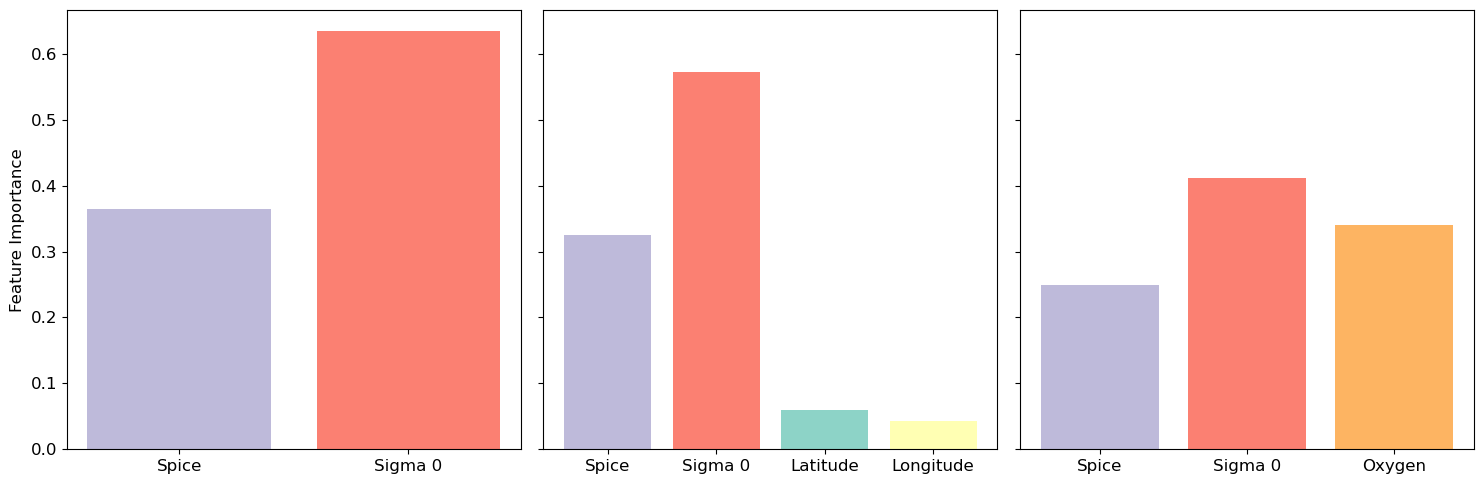

In [182]:
# combined feature importance

fig, ax = plt.subplots(1,3, figsize=(15,5), tight_layout=True, sharey=True)
ax=ax.flatten()
ax[0].bar(var_list_1, Mdl_1.feature_importances_, color = pald['Mdl_1'])
ax[0].set_ylabel('Feature Importance')
ax[1].bar(var_list_2, Mdl_2.feature_importances_, color = pald['Mdl_2'])
ax[2].bar(var_list_3, Mdl_3.feature_importances_, color = pald['Mdl_3'])


<BarContainer object of 7 artists>

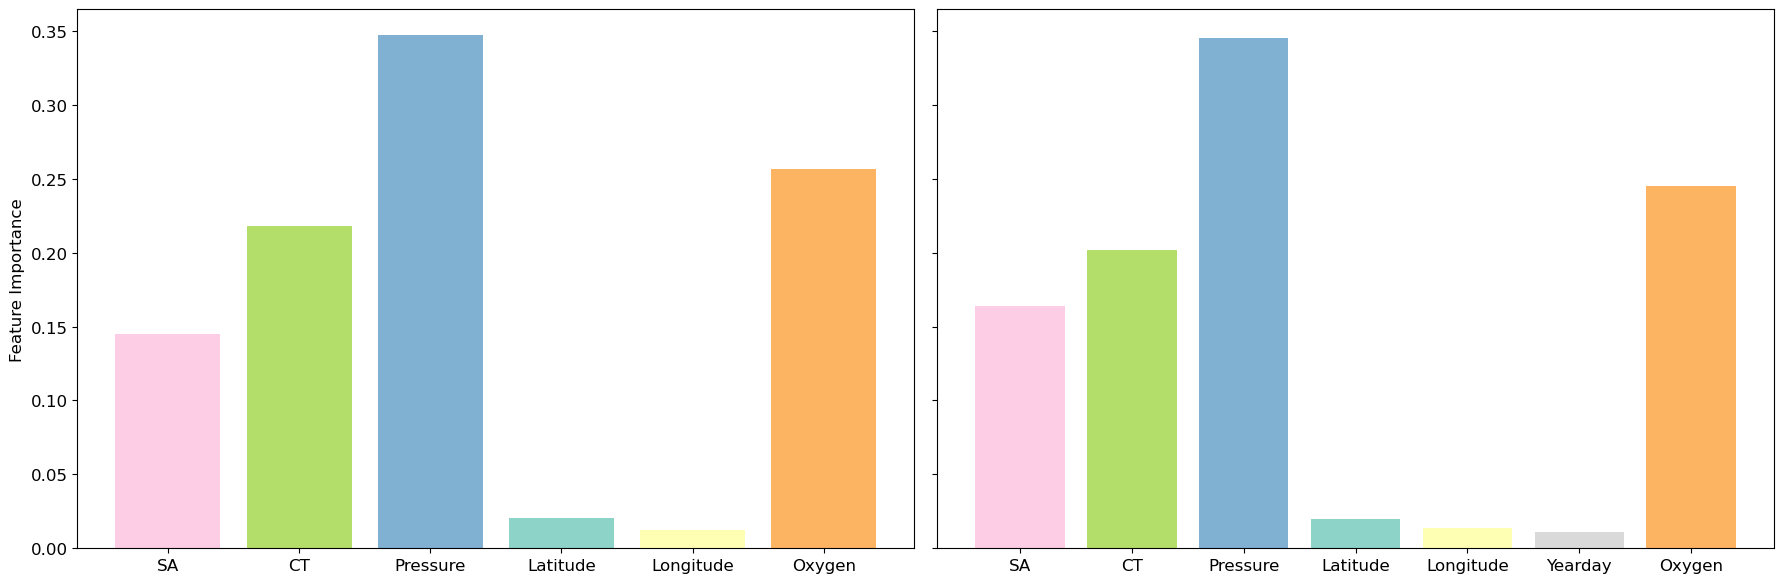

In [183]:
fig, ax = plt.subplots(1,2, figsize=(18,6), tight_layout=True, sharey=True)
ax=ax.flatten()
ax[0].bar(var_list_4, Mdl_4.feature_importances_, color = pald['Mdl_4'])
ax[0].set_ylabel('Feature Importance')
ax[1].bar(var_list_5, Mdl_5.feature_importances_, color = pald['Mdl_5'])



In [189]:
importlib.reload(sg)

<module 'sogos_module' from '/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/CourseCode/MLGEO2022_sangsong/ml-sogos/scripts/sogos_module.py'>

In [162]:
def plotx_nprof(g3, vars = ['SA', 'CT'], tag='', c = cmo.matter, save=False, lim=[]):
    """
    Plot over profile number. Faster than scatterplot by days because of Dataset format.
    @param  g3: Pass either gridded dataset gp_ on pressure, or gi_ on isopycnals.
            vars: Options are ['SA', 'CT', 'oxygen', 'AOU', 'spice']
    """
    list = [];
    for v in vars:
        fig = plt.figure(figsize=(8,4))
        ax = fig.gca()

        if len(lim)==0:
            min =  g3[v].min()
            max =  g3[v].max()
        else:
            min = lim[0]
            max = lim[1]

        g3[v].plot(vmin=min, vmax=max, cmap=c, ax=ax)

        ax.margins(x=0.01)
        ax.invert_yaxis()
        ax.set_title(v + ' ' + tag)
        ax.set_xlabel('profile number')

        pngtitle = tag + '_' + v + '_nprof.png'
        if save:
            plt.savefig('figures/' + pngtitle, format='png')

        list.append(ax)

    return list

In [137]:
print(gp_659.pH_1.min())
print(gp_659.pH_1.max())

<xarray.DataArray 'pH_1' ()>
array(7.90949025)
<xarray.DataArray 'pH_1' ()>
array(8.08195226)


Text(0.5, 0, 'profile number')

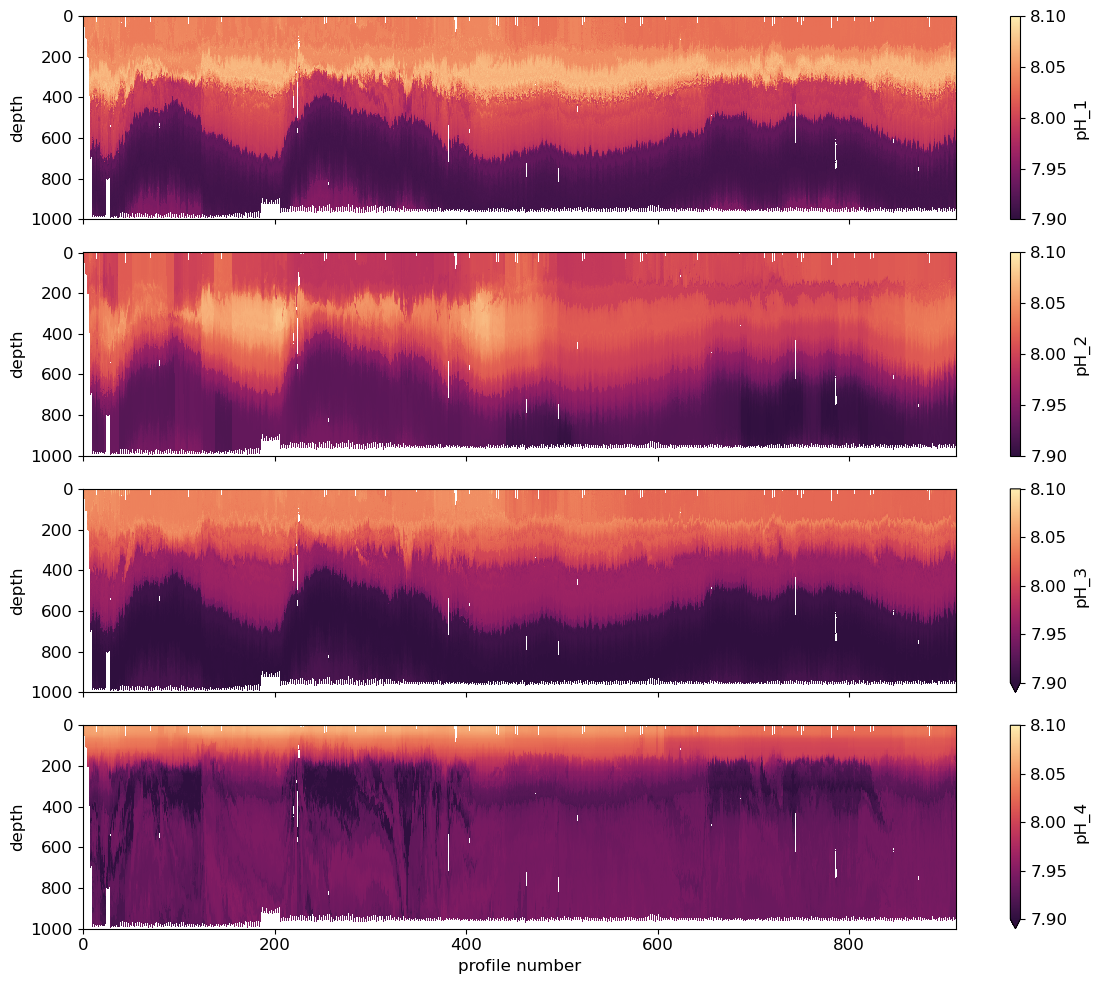

In [146]:
fig, axs = plt.subplots(4,1, figsize=(12,10), tight_layout=True, sharex=True)
ax = axs.flatten()

min=7.9
max=8.1
c=cmo.matter_r
gp_659['pH_1'].plot(vmin=min, vmax=max, cmap=c, ax=ax[0])
gp_659['pH_2'].plot(vmin=min, vmax=max, cmap=c, ax=ax[1])
gp_659['pH_3'].plot(vmin=min, vmax=max, cmap=c, ax=ax[2])
gp_659['pH_4'].plot(vmin=min, vmax=max, cmap=c, ax=ax[3])

for a in ax:
    a.invert_yaxis()
    a.set_xlabel('')
ax[3].set_xlabel('profile number')


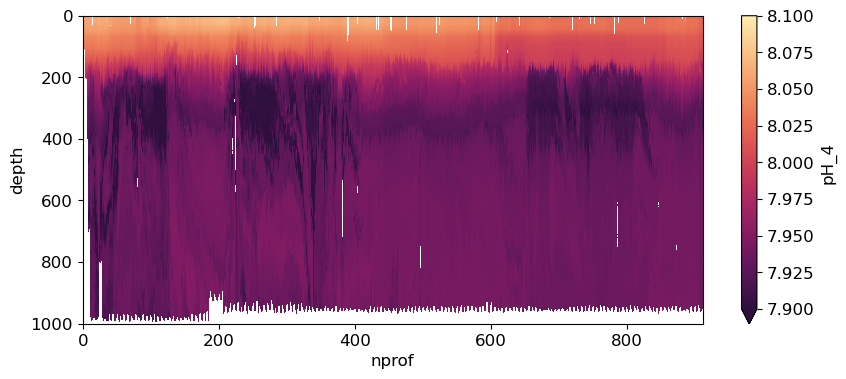

In [174]:
# axes = plotx_nprof(gp_659, vars = ['pH_4'], c=cmo.matter_r, tag='', save=False, lim=[])
# 'pH_1', 'pH_2', 'pH_3','CT'

min=7.9
max=8.1
fig = plt.figure(figsize=(10,4))
ax = fig.gca()
gp_659['pH_4'].plot(vmin=min, vmax=max, cmap=c, ax=ax)
ax.invert_yaxis()

In [186]:
gp_659

<xarray.Dataset>
Dimensions:     (depth: 1001, nprof: 912)
Coordinates:
  * nprof       (nprof) int64 0 1 2 3 4 5 6 7 ... 905 906 907 908 909 910 911
  * depth       (depth) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
Data variables:
    time        (depth, nprof) datetime64[ns] ...
    dive        (nprof) int16 ...
    lat         (depth, nprof) float32 ...
    lon         (depth, nprof) float32 ...
    speed       (depth, nprof) float32 ...
    P           (depth, nprof) float32 ...
    SA          (depth, nprof) float32 nan 33.98 nan 33.98 ... nan nan nan nan
    CT          (depth, nprof) float32 nan 3.506 nan 3.526 ... nan nan nan nan
    oxygen_raw  (depth, nprof) float32 ...
    sigma       (depth, nprof) float64 ...
    days        (depth, nprof) float64 ...
    buoyancy    (depth, nprof) float64 ...
    oxygen      (depth, nprof) float64 ...
    pH_1        (depth, nprof) float64 nan nan nan 8.042 nan ... nan nan nan nan
    pH_2        (depth, nprof) float64 nan nan nan 8.012 nan ... nan nan nan nan
    pH_3        (depth, nprof) float64 nan nan nan 8.047 nan ... nan nan nan nan
    pH_4        (depth, nprof) float64 nan nan nan 8.058 nan ... nan nan nan nan
Attributes:
    id:                              sg659_level3
    time_coverage_resolution:        PT1S
    geospatial_vertical_units:       meter
    geospatial_vertical_resolution:  meter
    geospatial_vertical_positive:    no
    platform:                        glider
    geospatial_lat_units:            degrees
    geospatial_lat_resolution:       seconds
    geospatial_lon_units:            degrees
    geospatial_lon_resolution:       seconds
    institution:                     Applied Physics Lab, University of Washi...
    license:                         These data may be redistributed and used...
    keywords_vocabulary:             NASA/GCMD Earth Science Keywords Version...
    references:                      http://data.nodc.noaa.gov/accession/0092291
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Conventions:                     CF-1.6
    standard_name_vocabulary:        CF-1.6
    featureType:                     trajectoryProfile
    nodc_template_version:           NODC_NetCDF_Trajectory_Template_v0.9
    naming_authority:                edu.washington.apl
    creator_name:                    Luc Rainville
    creator_url:                     https://iop.apl.washington.edu
    creator_email:                   lucrain@uw.edu
    platform_id:                     SG659
    source:                          Seaglider SG659
    summary:                         SG659 SOGOS April 2019
    project:                         SOGOS April 2019
    glider:                          659
    mission:                         2
    seaglider_software_version:      66.12
    base_station_version:            3.0
    base_station_micro_version:      0
    quality_control_version:         1.12
    processing_level:                1.12
    instrument:                      aa4831 sbe41 wlbb2fl 
    title:                           Physical, chemical, and biological data ...
    keywords:                        Water Temperature, Conductivity, Salinit...
    geospatial_lon_min:              30.04640
    geospatial_lon_max:              67.79239
    geospatial_lat_min:              -53.45803
    geospatial_lat_max:              -45.64820
    time_coverage_start:             2019-04-30T13:58:31Z
    time_coverage_end:               2019-11-25T03:53:12Z
    time_coverage_duration:          P0000-00-208T13:54:40
    geospatial_vertical_min:         0.00
    geospatial_vertical_max:         1000.00
    date_created:                    2021-09-24T17:29:48Z
    date_modified:                   2021-09-24T17:29:48Z
    uuid:                            0440e19e-1d5d-11ec-9be7-acde48001122

In [187]:
# Adding spice as a glider variable using gsw
def add_spice(gp_glider):
    spice = gsw.spiciness0(gp_glider['SA'], gp_glider['CT']) # referenced to surface 0 dbar

    # Adding spice as a variable to the glider (xarray) Dataset
    # You can only add (xarray) DataArrays to a Dataset (and not numpy arrays)
    # Anytime you need to add a new variable, you can do it in this format:
    gp_glider["spice"] = xr.DataArray(spice, dims = ["depth", "nprof"], 
                         coords = [gp_glider.depth.values, gp_glider.nprof.values] )
    return gp_glider

# def add_spice_iso(gi_glider):
#     spice = gsw.spiciness0(gi_glider['SA'], gi_glider['CT']) # referenced to surface 0 dbar
#     gi_glider["spice"] = xr.DataArray(spice, dims = ["sigma", "nprof"], 
#                          coords = [gi_glider.sigma.values, gi_glider.nprof.values] )
    return gi_glider
gp_659 = add_spice(gp_659); gp_660 = add_spice(gp_660)
# gi_659 = add_spice_iso(gi_659); gi_660 = add_spice_iso(gi_660)

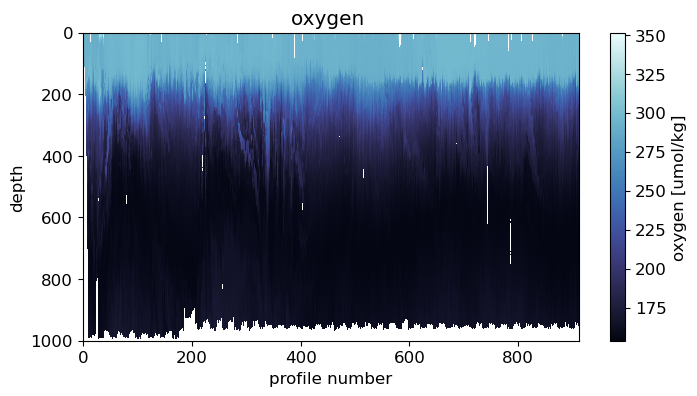

In [199]:
axes = plotx_nprof(gp_659, vars = ['oxygen'], c=cmo.ice, tag='', save=False, lim=[])
# axes = plotx_nprof(gp_659, vars = ['pH_4'], c=cmo.matter_r, tag='', save=False, lim=[])
# axes = plotx_nprof(gp_659, vars = ['SA'], c=cmo.haline, tag='', save=False, lim=[])

Text(0.5, 1.0, 'glider 660 temperature')

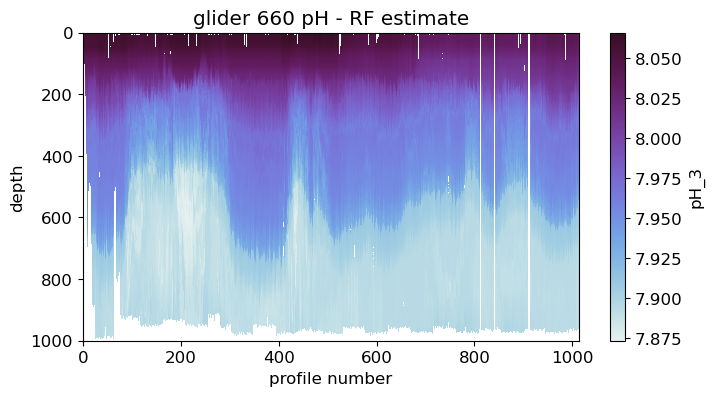

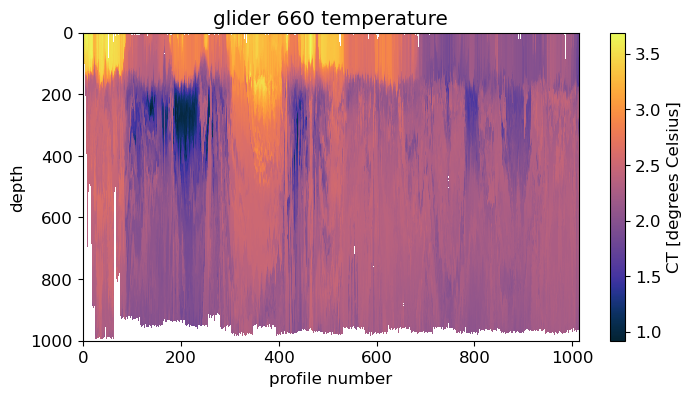

In [184]:
ax = sg.plot_var(gp_660, 'pH_3', cm=cmo.dense)
ax.set_title('glider 660 pH - RF estimate')
# sg.plot_var(gp_660, 'CT')
ax = sg.plot_var(gp_660, 'CT', cm=cmo.thermal)
ax.set_title('glider 660 temperature')


In [ ]:
# could plot difference metric over time
# for example, take average of models as mean, then plot sum of differences between each model and the mean over time
# are there periods of time in which the models have more inconsistencies between them? 


---
# Figures